In [1]:
#KÜTÜPHANELER

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [2]:
df = pd.read_csv("nba.csv")

#Veri Kaynağı: https://www.kaggle.com/davra98/nba-players-20162019

In [3]:
df.head()

,Rk,Player.x,Player_ID,Pos1,Pos2,Age,Tm,G,GS,MP,...,Conference,Role,Fvot,FRank,Pvot,PRank,Mvot,MRank,Score,Play
0,189,Aaron Gordon,gordoaa01,PF,NaN,23,ORL,78,78,33.8,...,Est,Front,94489,24,10,17,0,7,50.8,No
1,229,Aaron Holiday,holidaa01,PG,NaN,22,IND,50,0,12.9,...,Est,Back,9819,63,1,43,0,8,73.2,No
2,371,Abdel Nader,naderab01,SF,NaN,25,OKC,61,1,11.4,...,West,Front,29254,57,0,84,0,8,121.0,No
3,13,Al-Farouq Aminu,aminual01,PF,NaN,28,POR,81,81,28.3,...,West,Front,26552,65,5,28,0,8,76.2,No
4,236,Al Horford,horfoal01,C,NaN,32,BOS,68,68,29.0,...,Est,Front,360988,10,7,22,0,7,45.0,No


In [4]:
df.shape

(474, 45)

Veri seti, 474 NBA oyuncusuna ait bir veri seti. Oyunculara ait hangi takımda oynuyorlar, sayı ortalamaları, oynadıkları dakika ortalamaları vs. gibi bilgiler içeren bir veri seti. Biz bu veri setini kullanarak K-Means algoritması ile oyuncuları kümelendirmeyi amaçlıyoruz.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474 entries, 0 to 473
Data columns (total 45 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Rk          474 non-null    int64  
 1   Player.x    474 non-null    object 
 2   Player_ID   474 non-null    object 
 3   Pos1        474 non-null    object 
 4   Pos2        8 non-null      object 
 5   Age         474 non-null    int64  
 6   Tm          474 non-null    object 
 7   G           474 non-null    int64  
 8   GS          474 non-null    int64  
 9   MP          474 non-null    float64
 10  FG          474 non-null    float64
 11  FGA         474 non-null    float64
 12  FG.         473 non-null    float64
 13  X3P         474 non-null    float64
 14  X3PA        474 non-null    float64
 15  X3P.        447 non-null    float64
 16  X2P         474 non-null    float64
 17  X2PA        474 non-null    float64
 18  X2P.        470 non-null    float64
 19  eFG.        473 non-null    f

## Veri Ön İşleme

In [6]:
#Öncelikle df_model isminde yeni bir değişkeni df'e eşitliyoruz. df üzerinde oynama yapmayacağız. df_model değişkeninini
#hazırlayıp modele sokacağız.

df_model = df


#Modele sokmayacağımız sütunları df_model'den siliyoruz.

df_model = df_model.rename(columns = {"Player.x" : "Player_x"})
df_model = df_model.drop(columns = {"Player_x", "Player_ID", "Rk"})

Tektek sütunları inceleyeceğiz gerek gördüğümüz şeyleri bu aşamada uygulayıp veriyi hazırlayacağız.

In [7]:
print("Eksik veri toplamı:", df_model.Pos1.isnull().sum())
df_model["Pos1"].value_counts()

Eksik veri toplamı: 0


SG    119
PF    100
PG     98
C      87
SF     70
Name: Pos1, dtype: int64

Oyuncuların oynadıkları pozisyon hakkında bilgi veren değişken. One-Hot Encoding yapacağız.

In [8]:
#One-Hot Encoding
df_model = pd.get_dummies(df_model, columns = ["Pos1"], prefix = ["Pos1"])

In [9]:
print("Eksik veri toplamı:", df_model.Pos2.isnull().sum())

Eksik veri toplamı: 466


Çok eksik veri var ve pozisyon bilgisi zaten bir önceki değişkende de var olduğu için siliyoruz.

In [10]:
df_model = df_model.drop(columns = "Pos2")

In [11]:
print("Eksik veri toplamı:", df_model.Age.isnull().sum())
df_model.Age.describe()

Eksik veri toplamı: 0


count    474.000000
mean      25.911392
std        4.233232
min       19.000000
25%       23.000000
50%       25.000000
75%       29.000000
max       42.000000
Name: Age, dtype: float64

Oyuncuların yaşları hakkında bilgi veren değişken. Bir sıkıntı görünmüyor.

In [12]:
print("Eksik veri toplamı:", df_model.Tm.isnull().sum())
df_model["Tm"].value_counts()

Eksik veri toplamı: 0


PHI    19
MIL    18
LAC    18
UTA    17
LAL    17
MEM    17
CHO    17
IND    17
GSW    16
TOR    16
WAS    16
DAL    16
MIN    16
OKC    16
DET    16
NOP    16
DEN    16
CHI    15
CLE    15
POR    15
BRK    15
BOS    15
ORL    15
MIA    15
HOU    15
SAS    14
NYK    14
PHO    14
ATL    14
SAC    14
Name: Tm, dtype: int64

NBA'i takip edenler bilecektir ki oyuncuların oynadıkları takımlar ile kendi kaliteleri arasında aslında çok da doğrusal bir ilişki yoktur, en azından bence böyle. Bu sebepten ötürü bu sütunu modele sokmayacağız. Siliyoruz.

In [13]:
df_model = df_model.drop(columns = "Tm")

In [14]:
print("Eksik veri toplamı:", df_model.G.isnull().sum())
df_model.G.describe()

Eksik veri toplamı: 0


count    474.000000
mean      53.438819
std       23.611582
min        1.000000
25%       37.000000
50%       59.500000
75%       74.000000
max       82.000000
Name: G, dtype: float64

Oyuncunun çıktığı maç sayısı. Herhangi bir sıkıntı görünmüyor.

In [15]:
print("Eksik veri toplamı:", df_model.GS.isnull().sum())
df_model.GS.describe()

Eksik veri toplamı: 0


count    474.000000
mean      25.584388
std       28.540729
min        0.000000
25%        1.000000
50%       13.000000
75%       51.000000
max       82.000000
Name: GS, dtype: float64

Oyuncunun ilk 5 başladığı maç sayısı. Bir sıkıntı görünmüyor.

In [16]:
print("Eksik veri toplamı:", df_model.MP.isnull().sum())
df_model.MP.describe()

Eksik veri toplamı: 0


count    474.000000
mean      20.244515
std        8.822752
min        0.700000
25%       13.400000
50%       20.050000
75%       27.475000
max       36.900000
Name: MP, dtype: float64

Oyuncunun süre aldığı dakika. Bir sıkıntı görünmüyor.

In [17]:
print("Eksik veri toplamı:", df_model.FG.isnull().sum())
df_model.FG.describe()

Eksik veri toplamı: 0


count    474.000000
mean       3.361603
std        2.210680
min        0.000000
25%        1.700000
50%        2.800000
75%        4.500000
max       10.800000
Name: FG, dtype: float64

Oyuncunun maç başına başarılı olduğu ortalama atış sayısı. Sıkıntı görünmüyor.

In [18]:
print("Eksik veri toplamı:", df_model.FGA.isnull().sum())
df_model.FGA.describe()

Eksik veri toplamı: 0


count    474.000000
mean       7.383122
std        4.595826
min        0.000000
25%        4.000000
50%        6.400000
75%        9.875000
max       24.500000
Name: FGA, dtype: float64

Oyuncunun maç başına denediği ortalama atış sayısı. Sıkıntı görünmüyor.

In [19]:
df_model = df_model.rename(columns = {"FG." : "FG_"})

print("Eksik veri toplamı:", df_model.FG_.isnull().sum())
df_model.FG_.describe()

Eksik veri toplamı: 1


count    473.000000
mean       0.445873
std        0.089334
min        0.000000
25%        0.405000
50%        0.440000
75%        0.487000
max        0.716000
Name: FG_, dtype: float64

Atış yüzdesi. 1 tane eksik veri var buna bakacağız.

In [20]:
df_model[df_model.FG_.isnull()][{"FG", "FGA", "FG_"}]

,FGA,FG,FG_
155,0.0,0.0,NaN


"FG_" sütunundaki boş değer aslında 0 olması gereken bir değer. Bu yüzden eksik değeri 0 ile dolduruyoruz.

In [21]:
df_model.FG_ = df_model.FG_.fillna(0)

In [22]:
print("Eksik veri toplamı:", df_model.X3P.isnull().sum())
df_model.X3P.describe()

Eksik veri toplamı: 0


count    474.000000
mean       0.923840
std        0.805269
min        0.000000
25%        0.300000
50%        0.800000
75%        1.400000
max        5.100000
Name: X3P, dtype: float64

Oyuncunun maç başına ortalama başarılı olduğu 3'lük atış sayısı. Sıkıntı görünmüyor.

In [23]:
print("Eksik veri toplamı:", df_model.X3PA.isnull().sum())
df_model.X3PA.describe()

Eksik veri toplamı: 0


count    474.000000
mean       2.643249
std        2.108817
min        0.000000
25%        1.000000
50%        2.300000
75%        3.900000
max       13.200000
Name: X3PA, dtype: float64

Oyuncunun maç başına denediği ortalama 3'lük atış sayısı.

In [24]:
df_model = df_model.rename(columns = {"X3P." : "X3P_"})

print("Eksik veri toplamı:", df_model.X3P_.isnull().sum())
df_model.X3P_.describe()

Eksik veri toplamı: 27


count    447.000000
mean       0.316613
std        0.115638
min        0.000000
25%        0.294000
50%        0.336000
75%        0.369500
max        1.000000
Name: X3P_, dtype: float64

3'lük atış yüzdesi. 27 tane eksik veri var onlara bakacağız. Oranın %100 olması aykırı bir durum buna bakacağız.

In [25]:
df_model[df_model.X3P_.isnull()][{"X3P", "X3PA", "X3P_"}]

,X3PA,X3P_,X3P
14,0.0,NaN,0.0
21,0.0,NaN,0.0
22,0.0,NaN,0.0
32,0.0,NaN,0.0
65,0.0,NaN,0.0
74,0.0,NaN,0.0
96,0.0,NaN,0.0
125,0.0,NaN,0.0
128,0.0,NaN,0.0
135,0.0,NaN,0.0


Tıpkı "FG_" sütununda ki eksik veriler olduğu gibi bu eksik verilerde aslında 0 olması gereken eksik veriler. Eksik verileri 0 ile dolduruyoruz.

In [26]:
df_model.X3P_ = df_model.X3P_.fillna(0)

In [27]:
df_model[df_model.X3P_ == 1][{"X3P", "X3PA", "X3P_"}]

,X3PA,X3P_,X3P
142,0.2,1.0,0.2
435,0.3,1.0,0.3


Burada da az deneme yapıldığından ötürü bu orana ulaşıldığı gözlemleniyor. Bu modelin öğrenmesini etkileyebilecek, modeli yanıltabilecek bir durum. Bu değerleri ortalama değerlere eşitliyoruz.

In [28]:
df_model.X3P_[df_model.X3P_ == 1] = df_model["X3P_"].mean()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [29]:
print("Eksik veri toplamı:", df_model.X2P.isnull().sum())
df_model.X2P.describe()

Eksik veri toplamı: 0


count    474.000000
mean       2.438397
std        1.845021
min        0.000000
25%        1.100000
50%        1.900000
75%        3.300000
max        9.300000
Name: X2P, dtype: float64

Oyuncunun maç başına ortalama başarılı olduğu 2'lik atış sayısı.

In [30]:
print("Eksik veri toplamı:", df_model.X2PA.isnull().sum())
df_model.X2PA.describe()

Eksik veri toplamı: 0


count    474.000000
mean       4.740506
std        3.387935
min        0.000000
25%        2.200000
50%        3.750000
75%        6.675000
max       16.500000
Name: X2PA, dtype: float64

Oyuncunun maç başına denediği ortalama 2'lik atış sayısı.

In [31]:
df_model = df_model.rename(columns = {"X2P." : "X2P_"})

print("Eksik veri toplamı:", df_model.X2P_.isnull().sum())
df_model.X2P_.describe()

Eksik veri toplamı: 4


count    470.000000
mean       0.502683
std        0.087634
min        0.000000
25%        0.459500
50%        0.503500
75%        0.552750
max        0.727000
Name: X2P_, dtype: float64

2'lik atış yüzdesi. 4 tane eksik veri var bunlara bakacağız.

In [32]:
df_model[df_model.X2P_.isnull()][{"X2P", "X2PA", "X2P_"}]

,X2P_,X2P,X2PA
120,NaN,0.0,0.0
155,NaN,0.0,0.0
454,NaN,0.0,0.0
471,NaN,0.0,0.0


Bu eksik verilerde aslında 0 olması gereken veriler bu verileri de 0 yapıyoruz.

In [33]:
df_model.X2P_ = df_model.X2P_.fillna(0)

In [34]:
df_model = df_model.rename(columns = {"eFG." : "eFG_"})

print("Eksik veri toplamı:", df_model.eFG_.isnull().sum())
df_model.eFG_.describe()

Eksik veri toplamı: 1


count    473.000000
mean       0.507053
std        0.087089
min        0.000000
25%        0.477000
50%        0.513000
75%        0.553000
max        0.833000
Name: eFG_, dtype: float64

"Effective Field Goal Percentage" diye geçen bir istatistik bu da. Tam olarak neyi ifade ettiğini çözemedim ben. Ama eksik veri var buna bakacağız.

In [35]:
df_model[df_model.eFG_.isnull()][{"X2P", "X2PA", "X2P_","X3P", "X3PA", "X3P_", "eFG_"}]

,X2P_,X3P_,X2PA,X3PA,X3P,X2P,eFG_
155,0.0,0.0,0.0,0.0,0.0,0.0,NaN


Buradaki eksik verilerde aslında 0 olması gereken veriler bunları da 0'a eşitliyoruz.

In [36]:
df_model.eFG_ = df_model.eFG_.fillna(0)

In [37]:
print("Eksik veri toplamı:", df_model.FT.isnull().sum())
df_model.FT.describe()

Eksik veri toplamı: 0


count    474.000000
mean       1.439030
std        1.338808
min        0.000000
25%        0.500000
50%        1.000000
75%        1.900000
max        9.700000
Name: FT, dtype: float64

Oyuncunun maç başına başarılı olduğu ortalama serbest atış sayısı.

In [38]:
print("Eksik veri toplamı:", df_model.FTA.isnull().sum())
df_model.FTA.describe()

Eksik veri toplamı: 0


count    474.000000
mean       1.900211
std        1.667631
min        0.000000
25%        0.800000
50%        1.400000
75%        2.500000
max       11.000000
Name: FTA, dtype: float64

Oyuncunun ortalama olarak bir maçta denediği serbest atış sayısı. Sıkıntı görünmüyor.

In [39]:
df_model = df_model.rename(columns = {"FT." : "FT_"})

print("Eksik veri toplamı:", df_model.FT_.isnull().sum())
df_model.FT_.describe()

Eksik veri toplamı: 13


count    461.000000
mean       0.737677
std        0.125980
min        0.000000
25%        0.682000
50%        0.758000
75%        0.820000
max        1.000000
Name: FT_, dtype: float64

Serbest atış yüzdesi. 13 eksik veri var bunlara bakacağız. Oranın %100 olması aykırı bir durum buna bakacağız.

In [40]:
df_model[df_model.FT_.isnull()][{"FT_", "FT", "FTA"}]

,FT_,FT,FTA
91,NaN,0.0,0.0
120,NaN,0.0,0.0
142,NaN,0.0,0.0
155,NaN,0.0,0.0
173,NaN,0.0,0.0
185,NaN,0.0,0.0
210,NaN,0.0,0.0
226,NaN,0.0,0.0
435,NaN,0.0,0.0
440,NaN,0.0,0.0


Eksik verileri sıfıra eşitliyoruz.

In [41]:
df_model.FT_ = df_model.FT_.fillna(0)

In [42]:
df_model[df_model.FT_ == 1][{"FT_", "FT", "FTA"}]

,FT_,FT,FTA
101,1.0,0.7,0.7
152,1.0,0.1,0.1
199,1.0,0.3,0.3
295,1.0,0.1,0.1
340,1.0,0.1,0.1
443,1.0,0.2,0.2


Yine az deneme yapıldığı için bu oranı yakalamış olduğu görülüyor. Bu modelimizi yanıltabilecek bir durum. Bu değerleri ortalamaya eşitliyoruz.

In [43]:
df_model.FT_[df_model.FT_ == 1] = df_model["FT_"].mean()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [44]:
print("Eksik veri toplamı:", df_model.ORB.isnull().sum())
df_model.ORB.describe()

Eksik veri toplamı: 0


count    474.000000
mean       0.876371
std        0.799068
min        0.000000
25%        0.300000
50%        0.700000
75%        1.100000
max        5.400000
Name: ORB, dtype: float64

Maç başı alınan hücum ribaund sayısı. Sıkıntı görünmüyor.

In [45]:
print("Eksik veri toplamı:", df_model.DRB.isnull().sum())
df_model.DRB.describe()

Eksik veri toplamı: 0


count    474.000000
mean       2.910338
std        1.890423
min        0.000000
25%        1.600000
50%        2.500000
75%        3.700000
max       11.100000
Name: DRB, dtype: float64

Maç başı alınan savunma ribaund sayısı. Sıkıntı görünmüyor.

In [46]:
print("Eksik veri toplamı:", df_model.TRB.isnull().sum())
df_model.TRB.describe()

Eksik veri toplamı: 0


count    474.000000
mean       3.784599
std        2.534897
min        0.000000
25%        2.000000
50%        3.250000
75%        4.800000
max       15.600000
Name: TRB, dtype: float64

Maç başı alınan toplam ribaund sayısı. Sıkıntı görünmüyor.

In [47]:
print("Eksik veri toplamı:", df_model.AST.isnull().sum())
df_model.AST.describe()

Eksik veri toplamı: 0


count    474.000000
mean       2.029325
std        1.810611
min        0.000000
25%        0.800000
50%        1.400000
75%        2.600000
max       10.700000
Name: AST, dtype: float64

Maç başı yapılan asist sayısı. Sıkıntı görünmüyor.

In [48]:
print("Eksik veri toplamı:", df_model.STL.isnull().sum())
df_model.STL.describe()

Eksik veri toplamı: 0


count    474.000000
mean       0.641139
std        0.404017
min        0.000000
25%        0.300000
50%        0.600000
75%        0.900000
max        2.200000
Name: STL, dtype: float64

Oyuncunun maç başı çaldığı ortalama top sayısı. Sıkıntı görünmüyor.

In [49]:
print("Eksik veri toplamı:", df_model.BLK.isnull().sum())
df_model.BLK.describe()

Eksik veri toplamı: 0


count    474.000000
mean       0.412658
std        0.410651
min        0.000000
25%        0.100000
50%        0.300000
75%        0.500000
max        2.700000
Name: BLK, dtype: float64

Oyuncunun maç başı yaptığı blok sayısı. Sıkıntı görünmüyor.

In [50]:
print("Eksik veri toplamı:", df_model.TOV.isnull().sum())
df_model.TOV.describe()

Eksik veri toplamı: 0


count    474.000000
mean       1.132278
std        0.797136
min        0.000000
25%        0.600000
50%        0.900000
75%        1.500000
max        5.000000
Name: TOV, dtype: float64

Ortalama top kaybı sayısı. Sıkıntı görünmüyor.

In [51]:
print("Eksik veri toplamı:", df_model.PF.isnull().sum())
df_model.PF.describe()

Eksik veri toplamı: 0


count    474.000000
mean       1.797679
std        0.768551
min        0.000000
25%        1.300000
50%        1.800000
75%        2.300000
max        3.800000
Name: PF, dtype: float64

Ortalama yapılan faul sayısı. Sıkıntı görünmüyor.

In [52]:
print("Eksik veri toplamı:", df_model.PTS.isnull().sum())
df_model.PTS.describe()

Eksik veri toplamı: 0


count    474.000000
mean       9.082700
std        6.124207
min        0.000000
25%        4.625000
50%        7.500000
75%       12.100000
max       36.100000
Name: PTS, dtype: float64

Ortalama atılan sayı. Sıkıntı görünmüyor.

In [53]:
print("Eksik veri toplamı:", df_model.Salary.isnull().sum())
df_model.Salary.describe()

Eksik veri toplamı: 21


count    4.530000e+02
mean     7.285359e+06
std      8.153477e+06
min      5.684500e+04
25%      1.544951e+06
50%      3.382000e+06
75%      1.101123e+07
max      3.745715e+07
Name: Salary, dtype: float64

Oyuncuların aldıkları maaş tutarı. 21 eksik verimiz var bunları ortalama ile dolduracağız.

In [54]:
df_model.Salary[df_model.Salary.isnull()] = df_model["Salary"].mean()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [55]:
print("Eksik veri toplamı:", df_model.mean_views.isnull().sum())
df_model.mean_views.describe()

Eksik veri toplamı: 52


count      422.000000
mean      1072.646666
std       2220.339235
min          1.142857
25%        245.206164
50%        459.175342
75%       1003.144521
max      34147.961644
Name: mean_views, dtype: float64

Oyuncunun Wikipedia'da günlük aldığı görüntülenme sayısı. Eksik veriler var bunları ortalama değere eşitleyeceğiz.

In [56]:
df_model.mean_views[df_model.mean_views.isnull()] = df_model["mean_views"].mean()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [57]:
print("Eksik veri toplamı:", df_model.Season.isnull().sum())
df_model["Season"].value_counts()

Eksik veri toplamı: 0


2018-19    474
Name: Season, dtype: int64

Oyuncunun oynadığı sezon bilgisi. Bizim bu veri setini içinden aldığımız veri aslında 3 sezonluk bir setiydi ancak bizim içinden kestiğimiz veri setinde sadece 1 sezon olduğu için bu sütun bir şey ifade etmiyor bundan dolayı sileceğiz bu sütunu.

In [58]:
df_model = df_model.drop(columns = "Season")

In [59]:
print("Eksik veri toplamı:", df_model.Conference.isnull().sum())
df_model["Conference"].value_counts()

Eksik veri toplamı: 0


West    238
Est     236
Name: Conference, dtype: int64

Oyuncunun oynadığı konferans. Tıpkı takım sütununu sildiğimiz sebepten ötürü bu sütunu da siliyoruz.

In [60]:
df_model = df_model.drop(columns = "Conference")

In [61]:
print("Eksik veri toplamı:", df_model.Role.isnull().sum())
df_model["Role"].value_counts()

Eksik veri toplamı: 0


Front    255
Back     219
Name: Role, dtype: int64

Oyuncunun oynadığı rol ile alakalı ön veya geri şeklinde bize bilgi veriyor. Label Encoder yapacağız.

In [62]:
lbe = LabelEncoder()

df_model["Role"] = lbe.fit_transform(df_model["Role"])

#Front:1 Back:0 olacak şekilde dönüşüm yaptık.

In [63]:
print("Eksik veri toplamı:", df_model.Fvot.isnull().sum())
df_model.Fvot.describe()

Eksik veri toplamı: 0


count    4.740000e+02
mean     1.805977e+05
std      6.089716e+05
min      1.360000e+02
25%      4.243250e+03
50%      1.310800e+04
75%      6.549150e+04
max      4.620809e+06
Name: Fvot, dtype: float64

Bunun da tam olarak neyi ifade ettiğini anlamadım. Bir sıkıntı görünmüyor.

In [64]:
print("Eksik veri toplamı:", df_model.FRank.isnull().sum())
df_model.FRank.describe()

Eksik veri toplamı: 0


count    474.000000
mean      61.890295
std       36.443541
min        1.000000
25%       31.000000
50%       61.000000
75%       92.000000
max      138.000000
Name: FRank, dtype: float64

Bir sıkıntı görünmüyor.

In [65]:
print("Eksik veri toplamı:", df_model.Pvot.isnull().sum())
df_model.Pvot.describe()

Eksik veri toplamı: 0


count    474.000000
mean       7.651899
std       26.768507
min        0.000000
25%        0.000000
50%        1.000000
75%        4.000000
max      269.000000
Name: Pvot, dtype: float64

Bir sıkıntı görünmüyor.

In [66]:
print("Eksik veri toplamı:", df_model.PRank.isnull().sum())
df_model.PRank.describe()

Eksik veri toplamı: 0


count    474.000000
mean      47.968354
std       25.393667
min        1.000000
25%       26.000000
50%       52.000000
75%       61.000000
max       88.000000
Name: PRank, dtype: float64

Bir sıkıntı görünmüyor.

In [67]:
print("Eksik veri toplamı:", df_model.Mvot.isnull().sum())
df_model.Mvot.describe()

Eksik veri toplamı: 0


count    474.000000
mean       2.109705
std       12.920663
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      100.000000
Name: Mvot, dtype: float64

Bir sıkıntı görünmüyor.

In [68]:
print("Eksik veri toplamı:", df_model.MRank.isnull().sum())
df_model.MRank.describe()

Eksik veri toplamı: 0


count    474.000000
mean       7.078059
std        1.250887
min        1.000000
25%        6.000000
50%        7.000000
75%        8.000000
max        8.000000
Name: MRank, dtype: float64

Bir sıkıntı görünmüyor.

In [69]:
print("Eksik veri toplamı:", df_model.Score.isnull().sum())
df_model.Score.describe()

Eksik veri toplamı: 0


count    474.000000
mean      87.120464
std       38.238135
min        1.000000
25%       58.575000
50%       87.650000
75%      116.950000
max      161.500000
Name: Score, dtype: float64

Herhangi bir sıkıntı görünmüyor.

In [70]:
print("Eksik veri toplamı:", df_model.Play.isnull().sum())
df_model["Play"].value_counts()

Eksik veri toplamı: 0


No     448
Yes     26
Name: Play, dtype: int64

Oyuncunun All-Star'da oynayıp oynamadığı hakkında bilgi veren değişkebn. Label Encoder yapacağız.

In [71]:
lbe = LabelEncoder()

df_model["Play"] = lbe.fit_transform(df_model["Play"])

#Yes:1 Nol:0 olacak şekilde dönüşüm yaptık.

In [72]:
#Verimizin modele girecek son halini görelim.

df_model.head()

,Age,G,GS,MP,FG,FGA,FG_,X3P,X3PA,X3P_,...,PRank,Mvot,MRank,Score,Play,Pos1_C,Pos1_PF,Pos1_PG,Pos1_SF,Pos1_SG
0,23,78,78,33.8,6.0,13.4,0.449,1.6,4.4,0.349,...,17,0,7,50.8,0,0,1,0,0,0
1,22,50,0,12.9,2.1,5.2,0.401,0.9,2.5,0.339,...,43,0,8,73.2,0,0,0,1,0,0
2,25,61,1,11.4,1.5,3.5,0.423,0.5,1.6,0.320,...,84,0,8,121.0,0,0,0,0,1,0
3,28,81,81,28.3,3.2,7.3,0.433,1.2,3.5,0.343,...,28,0,8,76.2,0,0,1,0,0,0
4,32,68,68,29.0,5.7,10.6,0.535,1.1,3.0,0.360,...,22,0,7,45.0,0,1,0,0,0,0


In [73]:
#Standard Scaler uyguluyoruz bütün sütunlara
scaler = preprocessing.StandardScaler()

scaler.fit(df_model)
df_model = scaler.transform(df_model)

## K-Means Uygulama

D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


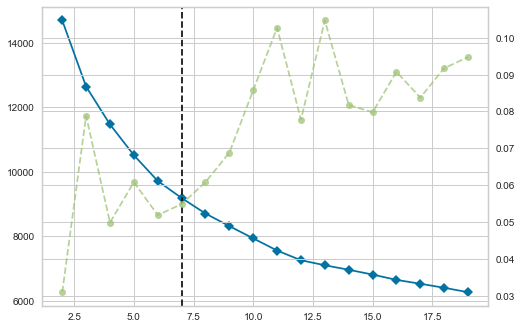

In [74]:
#En iyi sonucu verecek k değerini tespit edelim.

from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans(random_state = 44)
visu = KElbowVisualizer(kmeans, k = (2,20))
visu.fit(df_model);

k=6 en uygun küme sayısı değeri.

In [75]:
kmeans = KMeans(n_clusters = 6, random_state = 4)

k_fit = kmeans.fit(df_model)

k_fit.labels_

array([2, 4, 1, 2, 0, 4, 4, 4, 0, 1, 1, 5, 4, 4, 1, 1, 0, 4, 5, 2, 5, 5,
       1, 3, 1, 4, 1, 4, 4, 0, 5, 3, 1, 3, 1, 2, 2, 2, 4, 3, 5, 2, 4, 4,
       2, 4, 4, 2, 1, 5, 5, 4, 2, 2, 2, 1, 1, 1, 4, 1, 5, 1, 2, 1, 2, 0,
       0, 2, 4, 4, 1, 2, 2, 1, 1, 3, 4, 4, 5, 1, 2, 4, 1, 4, 1, 2, 1, 2,
       5, 4, 1, 5, 2, 4, 4, 0, 0, 4, 2, 0, 1, 1, 2, 2, 5, 0, 1, 2, 4, 2,
       4, 1, 4, 0, 4, 4, 4, 0, 2, 4, 5, 1, 1, 1, 2, 1, 1, 4, 0, 0, 2, 5,
       4, 0, 5, 1, 2, 4, 2, 0, 2, 2, 5, 1, 2, 4, 4, 1, 4, 4, 4, 4, 1, 2,
       4, 5, 1, 4, 3, 1, 2, 2, 1, 4, 1, 1, 4, 2, 1, 0, 1, 4, 1, 5, 4, 5,
       5, 1, 1, 4, 4, 1, 0, 4, 2, 5, 2, 5, 2, 1, 1, 1, 4, 1, 4, 2, 1, 3,
       1, 5, 1, 1, 5, 1, 0, 1, 5, 0, 1, 0, 5, 4, 2, 5, 2, 2, 2, 2, 2, 4,
       4, 5, 4, 4, 2, 1, 5, 2, 2, 3, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 4, 1,
       2, 5, 4, 4, 4, 2, 4, 2, 2, 1, 0, 1, 4, 1, 5, 2, 0, 0, 3, 1, 1, 3,
       0, 4, 2, 4, 3, 4, 2, 2, 1, 1, 2, 5, 2, 1, 5, 2, 1, 4, 2, 2, 1, 3,
       0, 4, 1, 4, 4, 2, 3, 5, 2, 5, 2, 1, 3, 4, 1,

In [76]:
#Sütun isimlerindeki "." ları "_" ye çeviriyoruz sıkıntı oluyor diğer türlü çünkü.
df = df.rename(columns = {"Player.x" : "Player_x", "FG." : "FG_", "X3P.": "X3P_", 
                          "X2P.": "X2P_", "eFG.": "eFG_", "FT.": "FT_",})


df["kume"] = k_fit.labels_

In [77]:
df.head()

,Rk,Player_x,Player_ID,Pos1,Pos2,Age,Tm,G,GS,MP,...,Role,Fvot,FRank,Pvot,PRank,Mvot,MRank,Score,Play,kume
0,189,Aaron Gordon,gordoaa01,PF,NaN,23,ORL,78,78,33.8,...,Front,94489,24,10,17,0,7,50.8,No,2
1,229,Aaron Holiday,holidaa01,PG,NaN,22,IND,50,0,12.9,...,Back,9819,63,1,43,0,8,73.2,No,4
2,371,Abdel Nader,naderab01,SF,NaN,25,OKC,61,1,11.4,...,Front,29254,57,0,84,0,8,121.0,No,1
3,13,Al-Farouq Aminu,aminual01,PF,NaN,28,POR,81,81,28.3,...,Front,26552,65,5,28,0,8,76.2,No,2
4,236,Al Horford,horfoal01,C,NaN,32,BOS,68,68,29.0,...,Front,360988,10,7,22,0,7,45.0,No,0


## Sonuç

In [78]:
pd.set_option('display.max_columns', None)

In [79]:
df.groupby('kume').mean()

,Rk,Age,G,GS,MP,FG,FGA,FG_,X3P,X3PA,X3P_,X2P,X2PA,X2P_,eFG_,FT,FTA,FT_,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Salary,mean_views,Fvot,FRank,Pvot,PRank,Mvot,MRank,Score
kume,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,254.111111,25.955556,67.733333,48.955556,26.135556,5.304444,9.624444,0.559533,0.375556,1.133333,0.265974,4.940000,8.488889,0.586244,0.577222,2.388889,3.402222,0.706489,2.615556,5.853333,8.471111,1.873333,0.746667,1.133333,1.575556,2.777778,13.388889,1.228864e+07,1111.042917,1.617280e+05,39.933333,7.933333,35.577778,0.044444,7.400000,66.668889
1,274.067164,25.962687,48.611940,9.947761,15.108955,2.084328,4.435821,0.480306,0.532090,1.557463,0.297933,1.548507,2.873881,0.542418,0.537336,0.829104,1.176866,0.707104,0.909701,2.445522,3.356716,0.897015,0.436567,0.429104,0.672388,1.650000,5.527612,4.530580e+06,455.867956,1.482157e+04,85.798507,0.791045,68.097015,0.000000,7.537313,114.148507
2,276.757895,26.652632,67.378947,55.189474,30.208421,5.537895,12.468421,0.443558,1.712632,4.738947,0.357958,3.826316,7.729474,0.496695,0.514126,2.445263,3.053684,0.791000,0.848421,3.843158,4.688421,3.706316,0.987368,0.428421,1.882105,2.249474,15.220000,1.197605e+07,1364.993227,2.497832e+05,29.463158,9.010526,24.715789,0.242105,7.073684,52.300000
3,232.111111,26.722222,72.166667,72.166667,34.433333,8.916667,18.627778,0.482722,2.272222,6.333333,0.328000,6.644444,12.283333,0.538278,0.541222,5.383333,6.766667,0.796944,1.455556,6.627778,8.077778,6.116667,1.372222,0.783333,3.150000,2.483333,25.494444,2.521865e+07,6752.505175,2.656524e+06,3.666667,119.888889,3.111111,54.166667,2.888889,5.150000
4,249.174603,26.365079,56.976190,16.119048,19.850794,2.745238,6.546825,0.419429,1.062698,3.014286,0.340492,1.684921,3.537302,0.479643,0.499786,0.931746,1.212698,0.768635,0.426984,2.000000,2.422222,2.069048,0.630159,0.227778,0.942063,1.656349,7.482540,4.703029e+06,756.990302,3.523840e+04,62.380952,0.992063,49.761905,0.000000,7.007937,90.561905
5,270.946429,23.214286,15.875000,0.321429,7.221429,0.766071,2.275000,0.321509,0.217857,0.878571,0.257902,0.546429,1.407143,0.382423,0.369109,0.301786,0.450000,0.632256,0.271429,0.928571,1.194643,0.616071,0.248214,0.064286,0.383929,0.694643,2.042857,1.369630e+06,292.344253,6.296089e+03,94.946429,0.446429,59.589286,0.000000,7.232143,116.555357


Kümeler arasında bir sıralama yapacak olursak en iyi kümenin Küme-3 olduğunu söyleyebiliriz. Daha sonrasında sıralama şöyle devam eder; Küme-2, Küme-0, Küme-4, Küme-1, Küme-5.

In [80]:
#En iyi küme olan Küme-3'de kimler olduğuna bakalım.

df[df.kume == 3]

,Rk,Player_x,Player_ID,Pos1,Pos2,Age,Tm,G,GS,MP,FG,FGA,FG_,X3P,X3PA,X3P_,X2P,X2PA,X2P_,eFG_,FT,FTA,FT_,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Salary,mean_views,Season,Conference,Role,Fvot,FRank,Pvot,PRank,Mvot,MRank,Score,Play,kume
23,126,Anthony Davis,davisan02,C,NaN,25,NOP,56,56,33.0,9.5,18.3,0.517,0.9,2.6,0.331,8.6,15.7,0.547,0.540,6.1,7.7,0.794,3.1,8.9,12.0,3.9,1.6,2.4,2.0,2.4,25.9,25434263.0,972.769863,2018-19,West,Front,2520728,5,136,3,66,3,4.0,Yes,3
31,448,Ben Simmons,simmobe01,PG,NaN,22,PHI,79,79,34.2,6.8,12.2,0.563,0.0,0.1,0.000,6.8,12.1,0.566,0.563,3.3,5.4,0.600,2.2,6.6,8.8,7.7,1.4,0.8,3.5,2.6,16.9,6434520.0,6145.054795,2018-19,Est,Back,1184221,4,43,5,25,3,4.0,Yes,3
33,202,Blake Griffin,griffbl01,PF,NaN,29,DET,75,75,35.0,8.3,17.9,0.462,2.5,7.0,0.362,5.7,10.9,0.525,0.532,5.5,7.3,0.753,1.3,6.2,7.5,5.4,0.7,0.4,3.4,2.7,24.5,31873932.0,4820.797260,2018-19,Est,Front,843785,6,50,5,0,7,38.8,Yes,3
39,40,Bradley Beal,bealbr01,SG,NaN,25,WAS,82,82,36.9,9.3,19.6,0.475,2.5,7.3,0.351,6.8,12.4,0.548,0.540,4.4,5.5,0.808,1.1,3.9,5.0,5.5,1.5,0.7,2.7,2.8,25.6,25434262.0,944.076712,2018-19,Est,Back,346027,10,62,3,7,5,7.0,Yes,3
75,305,Damian Lillard,lillada01,PG,NaN,28,POR,80,80,35.5,8.5,19.2,0.444,3.0,8.0,0.369,5.6,11.1,0.499,0.522,5.9,6.4,0.912,0.9,3.8,4.6,6.9,1.1,0.4,2.7,1.9,25.8,27977689.0,2140.838356,2018-19,West,Back,1043785,6,31,5,1,4,5.2,Yes,3
158,18,Giannis Antetokounmpo,antetgi01,PF,NaN,24,MIL,72,72,32.8,10.0,17.3,0.578,0.7,2.8,0.256,9.3,14.5,0.641,0.599,6.9,9.5,0.729,2.2,10.3,12.5,5.9,1.3,1.5,3.7,3.2,27.7,24157304.0,6641.391781,2018-19,Est,Front,4375747,1,269,1,99,1,1.0,Yes,3
197,206,James Harden,hardeja01,PG,NaN,29,HOU,78,78,36.8,10.8,24.5,0.442,4.8,13.2,0.368,6.0,11.3,0.528,0.541,9.7,11.0,0.879,0.8,5.8,6.6,7.5,2.0,0.7,5.0,3.1,36.1,30570000.0,5984.852055,2018-19,West,Back,2905488,3,153,2,99,1,2.2,Yes,3
229,155,Joel Embiid,embiijo01,C,NaN,24,PHI,64,64,33.7,9.1,18.7,0.484,1.2,4.1,0.300,7.8,14.6,0.535,0.517,8.2,10.1,0.804,2.5,11.1,13.6,3.7,0.7,1.9,3.5,3.3,27.5,25467250.0,4577.375342,2018-19,Est,Front,2783833,3,186,3,99,1,2.5,Yes,3
260,301,Kawhi Leonard,leonaka01,SF,NaN,27,TOR,60,60,34.0,9.3,18.8,0.496,1.9,5.0,0.371,7.5,13.8,0.542,0.546,6.1,7.1,0.854,1.3,6.0,7.3,3.3,1.8,0.4,2.0,1.5,26.6,23114066.0,6419.293151,2018-19,Est,Front,3580531,2,189,2,99,1,1.8,Yes,3
263,496,Kemba Walker,walkeke02,PG,NaN,28,CHO,82,82,34.9,8.9,20.5,0.434,3.2,8.9,0.356,5.7,11.6,0.494,0.511,4.6,5.5,0.844,0.6,3.8,4.4,5.9,1.2,0.4,2.6,1.6,25.6,12000000.0,1770.638356,2018-19,Est,Back,1395330,3,98,2,48,2,2.5,Yes,3


NBA Süper Yıldızları!!

Ve son olarak milli yıldızlarımız Cedi Osman ve Furkan Korkmaz'ın hangi kümede olduklarına ve istatistiklerine bakalım.

In [81]:
df[df.Player_x == "Cedi Osman"]

,Rk,Player_x,Player_ID,Pos1,Pos2,Age,Tm,G,GS,MP,FG,FGA,FG_,X3P,X3PA,X3P_,X2P,X2PA,X2P_,eFG_,FT,FTA,FT_,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Salary,mean_views,Season,Conference,Role,Fvot,FRank,Pvot,PRank,Mvot,MRank,Score,Play,kume
54,391,Cedi Osman,osmande01,SF,NaN,23,CLE,76,75,32.2,4.7,11.1,0.427,1.7,4.9,0.348,3.0,6.2,0.489,0.504,1.9,2.4,0.779,0.6,4.1,4.7,2.6,0.8,0.1,1.5,2.6,13.0,2775000.0,1419.761644,2018-19,Est,Front,101593,23,1,57,0,7,60.2,No,2


Cedi Küme-2 de.

In [82]:
df[df.Player_x == "Furkan Korkmaz"]

,Rk,Player_x,Player_ID,Pos1,Pos2,Age,Tm,G,GS,MP,FG,FGA,FG_,X3P,X3PA,X3P_,X2P,X2PA,X2P_,eFG_,FT,FTA,FT_,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Salary,mean_views,Season,Conference,Role,Fvot,FRank,Pvot,PRank,Mvot,MRank,Score,Play,kume
150,286,Furkan Korkmaz,korkmfu01,SG,NaN,21,PHI,48,7,14.1,2.0,5.1,0.4,1.0,3.0,0.326,1.1,2.1,0.505,0.496,0.8,0.9,0.818,0.3,1.9,2.2,1.1,0.6,0.0,0.5,1.3,5.8,1740000.0,368.739726,2018-19,Est,Back,61306,26,0,61,0,8,88.2,No,4


Furkan Küme-4 de.